In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString, GeometryCollection, box
from shapely.ops import split
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from matplotlib import pyplot as plt
from shapely.affinity import scale
from tqdm.auto import tqdm
pd.set_option('display.max_columns', None)

In [2]:
imd = gpd.read_file("input/IMD2018.zip")
df = imd.cx[1747618.6612:1768514.9720,5909569.6924:5922316.0159]
df = df[df.dhb2015_na == "Auckland"].copy()
df.set_index("DZ2018", inplace=True)
df.sample(1)

,Census_Pop,Count_MB18,dhb2015_co,dhb2015_na,ged2020num,ged2020nam,ta2020code,ta2020name,regc2020co,regc2020na,Rank_IMD18,Dec_IMD18,Rank_Emplo,Decile_Emp,Rank_Incom,Decile_Inc,Rank_Crime,Decile_Cri,Rank_Housi,Decile_Hou,Rank_Healt,Decile_Hea,Rank_Educa,Decile_Edu,Rank_Acces,Decile_Acc,RnkIMDNoEm,DecIMDNoEm,RnkIMDNoIn,DecIMDNoIn,RnkIMDNoCr,DecIMDNoCr,RnkIMDNoHo,DecIMDNoHo,RnkIMDNoHe,DecIMDNoHe,RnkIMDNoEd,DecIMDNoEd,RnkIMDNoAc,DecIMDNoAc,geometry
DZ2018,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7600754,942,6,3,Auckland,24,Mt Albert,76,Auckland,2,Auckland Region,3272,6,2029.5,4,2775,5,5284,9,5007,9,5280,9,395,1,283,1,3723,7,3468,6,3085,5,2944,5,2623,5,3635,6,3345,6,"POLYGON ((1755320.403 5916356.294, 1755317.618..."


<Axes: >

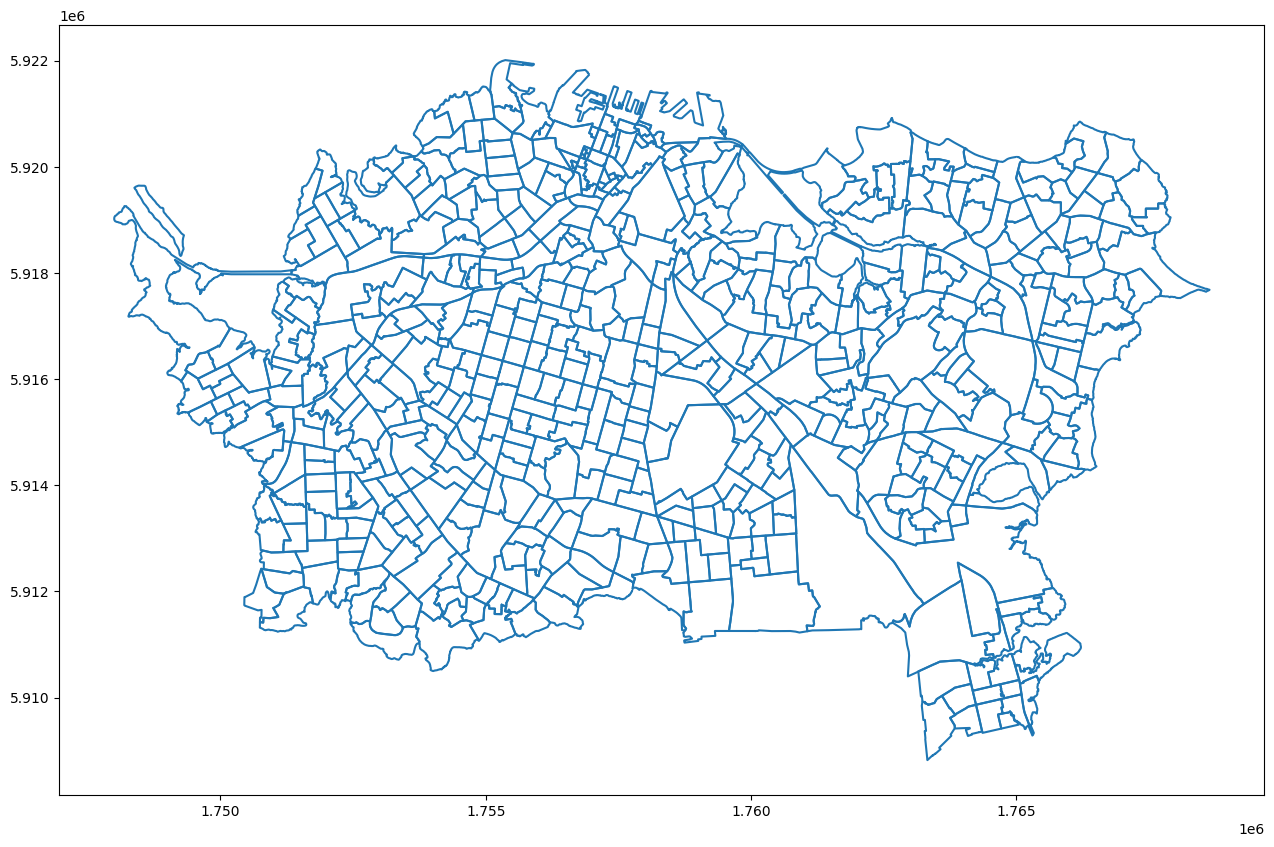

In [3]:
df.boundary.plot(figsize=(20,10))

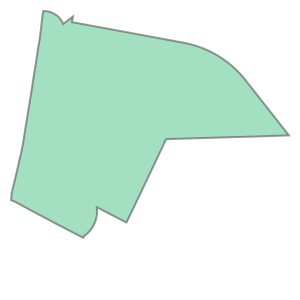

In [4]:
# Pick the most central polygon
start_index = df.distance(box(*df.total_bounds).centroid).idxmin()
start = df.geometry[start_index]
start

In [5]:
radius = start.centroid.distance(start.boundary)
radius

248.9962599862079

A hexagon is made of 6 equilateral triangles, with internal angles of 120 degrees. The internal angles of the equilateral triangles are all 60 degrees.

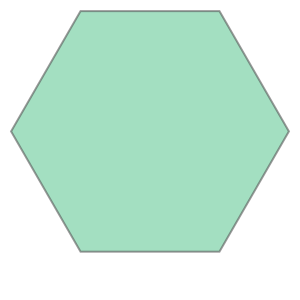

In [6]:
def create_hexagon(center, radius, rotate=False):
    """Create a hexagon centered at 'center' with a given 'radius', and include lines connecting each vertex to the center."""
    vertices = []
    for i in range(6):
        angle = math.radians(60 * i)  # Convert angle to radians
        if rotate:
            angle += math.radians(30)
        x = center.x + radius * math.cos(angle)  # X-coordinate
        y = center.y + radius * math.sin(angle)  # Y-coordinate
        vertices.append((x, y))  # Append vertex coordinates
    hexagon = Polygon(vertices)  # Create a polygon from the vertices
    return hexagon

start_hexagon = create_hexagon(start.centroid, radius)
assert start_hexagon.is_valid
start_hexagon

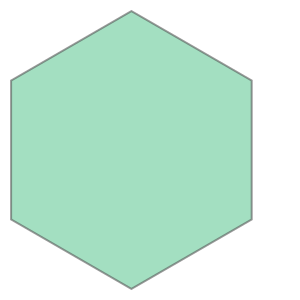

In [7]:
create_hexagon(start.centroid, radius, True)

Some options here for splitting up a hexagon to represent variables within. Here's the composite equilateral triangles:

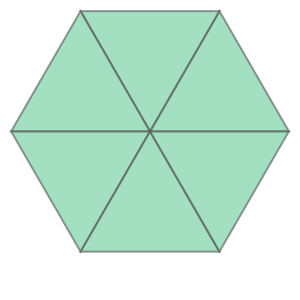

In [8]:
def hexagon_to_triangles(hexagon):
    center = hexagon.centroid
    vertices = list(hexagon.exterior.coords)
    triangles = []
    for i in range(6):
        next_i = (i + 1) % 6  # Wrap around to form a closed shape
        triangle = Polygon([center, vertices[i], vertices[next_i]])
        triangles.append(triangle)
    return GeometryCollection(triangles)

triangles = hexagon_to_triangles(start_hexagon)
assert triangles.is_valid
triangles

Evenly sliced along the vertical axis (y)

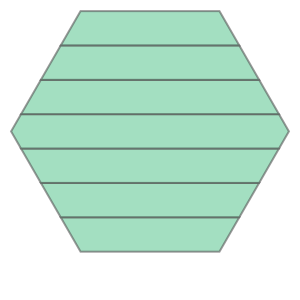

In [9]:
def slice_hexagon(hexagon, slices = 7):
  if hexagon is None:
    return None
  minx, miny, maxx, maxy = hexagon.bounds
  poly = hexagon
  segments = []
  slice_height = (maxy-miny) / slices
  for i in range(1, slices + 1):
    y = miny + slice_height * i
    parts = list(split(poly, LineString([(minx, y), (maxx, y)])).geoms)
    parts.sort(key=lambda p: p.bounds[1], reverse=True)
    #print(i, len(parts), [p.bounds[1] for p in parts], [p.area for p in parts])
    if len(parts) == 2:
      segments.append(parts[1])
      poly = parts[0]
    if i == slices:
      segments.append(parts[0])
  return GeometryCollection(segments)

slice_hexagon(start_hexagon)

Sub hexagons, with a nice star in the middle

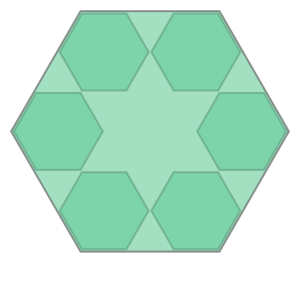

In [10]:
def sub_hexagons(hexagon):
    center = hexagon.centroid
    hexagons = []
    for i in range(6):
        angle = math.radians(60 * i + 0)  # Convert angle to radians
        x = center.x + radius * .66 * math.cos(angle)  # X-coordinate
        y = center.y + radius * .66 * math.sin(angle)  # Y-coordinate
        hexagons.append(create_hexagon(Point([x, y]), radius * .32))
    return GeometryCollection(hexagons)

GeometryCollection(list(sub_hexagons(start_hexagon).geoms) + [start_hexagon])

Better internal tesselation with rotated internal hexagons

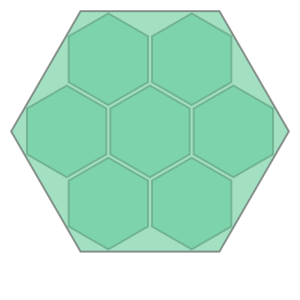

In [11]:
def sub_hexagons(hexagon):
    if hexagon is None:
        return None
    center = hexagon.centroid
    radius = start_hexagon.length / 6
    hexagons = [create_hexagon(center, radius * .33, True)]
    for i in range(6):
        angle = math.radians(60 * i + 0)  # Convert angle to radians
        x = center.x + radius * .6 * math.cos(angle)  # X-coordinate
        y = center.y + radius * .6 * math.sin(angle)  # Y-coordinate
        hexagons.append(create_hexagon(Point([x, y]), radius * .33, True))
    return GeometryCollection(hexagons)

sub = sub_hexagons(start_hexagon)
GeometryCollection(list(sub.geoms) + [start_hexagon])

<Axes: >

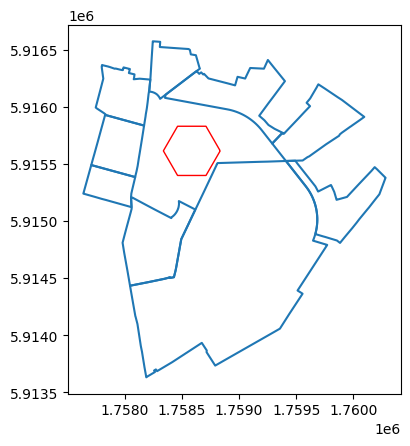

In [12]:
neighbours = df.geometry[df.touches(start)]
ax = neighbours.boundary.plot()
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

An equilateral triangle, split into two, makes two equal area triangles. The length of the line splitting the triangle, * 2, is the distance to the center of the neighbouring tesselated hexagon

215.63708659508544


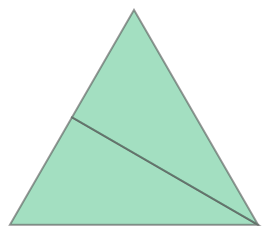

In [13]:
triangle = triangles.geoms[0]
v1, v2, v3 = set(triangle.exterior.coords)
midpoint = ((v1[0] + v2[0]) / 2, (v1[1] + v2[1]) / 2)
# Create a line from the midpoint to the opposite vertex
split_line = LineString([midpoint, v3])
print(split_line.length)
split_triangles = split(triangle, scale(split_line, yfact=1.001))
split_triangles

In [14]:
radius, split_line.length * 2

(248.9962599862079, 431.27417319017087)

Create the neighbouring 6 tesselating hexagons

<Axes: >

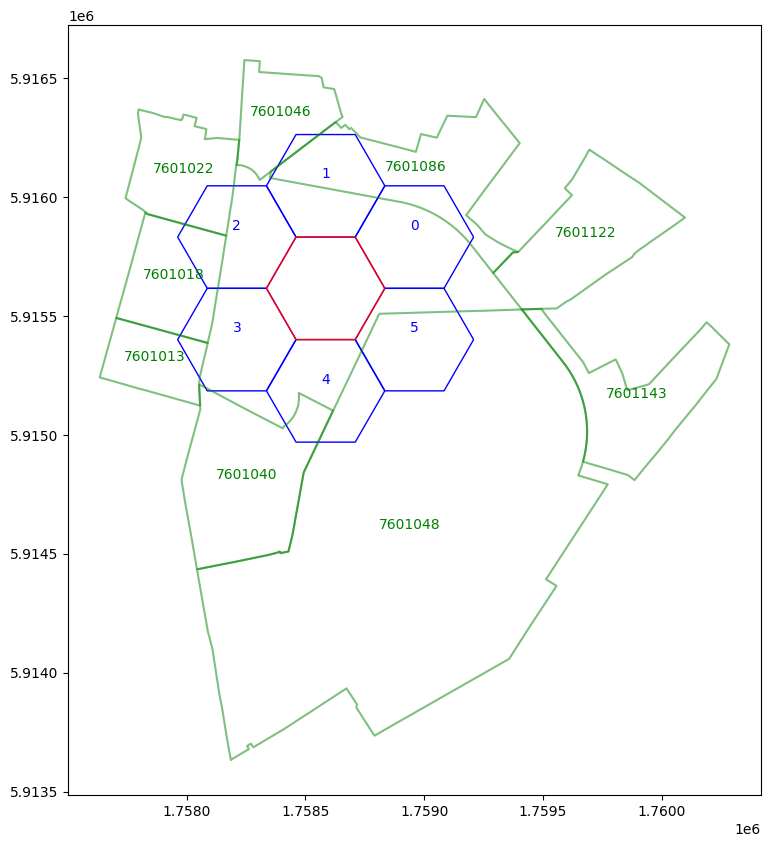

In [15]:
from shapely.geometry import Point
hex_neighbours = []
for i in range(6):
    angle = math.radians(60 * i + 30)  # Convert angle to radians
    x = start.centroid.x + split_line.length * 2 * math.cos(angle)  # X-coordinate
    y = start.centroid.y + split_line.length * 2 * math.sin(angle)  # Y-coordinate
    hex_neighbours.append(create_hexagon(Point([x, y]), radius))

hex_neighbours = gpd.GeoSeries(hex_neighbours, crs=df.crs)
ax = hex_neighbours.plot(edgecolor="blue", facecolor="none", figsize=(10,10))
for i in range(6):
  p = hex_neighbours.centroid.iloc[i]
  ax.annotate(text=str(i), xy=[p.x, p.y + radius / 8], ha='center', color="blue")
neighbours.boundary.plot(ax=ax, color="green", alpha=.5)
for i in neighbours.index:
  ax.annotate(text=str(i), xy=[neighbours.centroid[i].x, neighbours.centroid[i].y], ha='center', color="green")
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

                   0            1            2            3            4  \
DZ2018                                                                     
7601013  1209.978364  1029.473402   625.521258   356.329004   728.836412   
7601018  1026.866311   748.407590   317.467178   368.506986   793.812257   
7601022  1007.327761   599.671057   349.771073   734.968075  1093.289491   
7601040  1237.741595  1275.972172  1016.787074   586.094016   497.398700   
7601046   756.490725   347.056699   541.046548   957.519842  1169.903463   
7601048  1228.150402  1486.439318  1427.389245  1078.994826   680.500845   
7601086   278.519353   382.664195   800.937029  1033.300299   999.425161   
7601122   720.878592  1115.100316  1467.866438  1530.369980  1272.104360   
7601143  1156.012778  1585.619814  1814.736710  1701.330011  1310.228665   

                   5  
DZ2018                
7601013  1095.326964  
7601018  1043.775077  
7601022  1196.890757  
7601040   917.417297  
7601046  1093.796644  
76

<Axes: ylabel='DZ2018'>

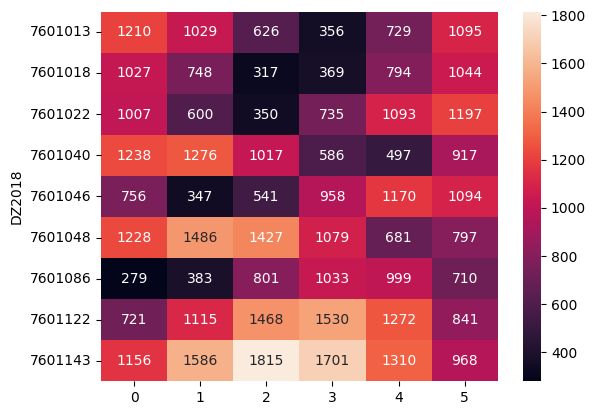

In [16]:
# Build a cost distance matrix
distance_matrix = neighbours.centroid.apply(lambda n: n.distance(hex_neighbours.centroid))
print(distance_matrix)
sns.heatmap(distance_matrix.round(), annot=True, fmt=".0f")

In [17]:
# Create a new hex_geo column to store best matching hexagons for each DZ
df["hex_geo"] = gpd.GeoSeries()
df.loc[start_index, "hex_geo"] = start_hexagon

In [18]:
# Find the optimal hexagons for each DZ, based on the distance matrix
row_ind, col_ind = linear_sum_assignment(distance_matrix)
distance_matrix.index[row_ind], hex_neighbours[col_ind]
df.loc[distance_matrix.index[row_ind], "hex_geo"] = hex_neighbours[col_ind].values

In [19]:
pbar = tqdm(total=sum(df.hex_geo.isna()))

def assign_neighbours(neighbour_index):
   # Recursive function, takes an index and assigns hexagons to its neighbours
   geometry = df.geometry[neighbour_index]
   neighbours = df.geometry[df.touches(geometry)]
   neighbours_to_process = set()
   for neighbour_index in neighbours.index:
      neighbour = neighbours[neighbour_index]
      neighbour_hex = df.hex_geo[neighbour_index]
      if not neighbour_hex:
          #print(f"{neighbour_index} is missing hex_geo")
          continue
      nn = df.geometry[df.hex_geo.isna() & df.touches(neighbour)]
      if len(nn) == 0:
         # No neighbours
         continue
      hex_neighbours = []
      for i in range(6):
            angle = math.radians(60 * i + 30)  # Convert angle to radians
            x = neighbour_hex.centroid.x + split_line.length * 2 * math.cos(angle)  # X-coordinate
            y = neighbour_hex.centroid.y + split_line.length * 2 * math.sin(angle)  # Y-coordinate
            hex = create_hexagon(Point([x, y]), radius)
            # Filter out already used hexagons
            if df.hex_geo.centroid.distance(hex.centroid).min() > 1:
               hex_neighbours.append(hex)

      if len(hex_neighbours) == 0:
         # No available hexagons
         #print(f"No available hexagons for {neighbour_index}")
         continue
      hex_neighbours = gpd.GeoSeries(hex_neighbours, crs=df.crs)
      neighbours_to_process.update(nn.index)
      # Build a cost distance matrix
      distance_matrix = nn.centroid.apply(lambda n: n.distance(hex_neighbours.centroid))
      row_ind, col_ind = linear_sum_assignment(distance_matrix)
      # Assign the optimal hexagons to each neighbour
      df.loc[distance_matrix.index[row_ind], "hex_geo"] = hex_neighbours[col_ind].values
      pbar.update(len(col_ind))
   for neighbour in neighbours_to_process:
       assign_neighbours(neighbour)

assign_neighbours(start_index)
pbar.close()
print(f"Assigned hexagons for {sum(~df.hex_geo.isna())} out of {len(df)} DZs")

  0%|          | 0/574 [00:00<?, ?it/s]

Assigned hexagons for 581 out of 581 DZs


In [20]:
rank_cols = ['Rank_Emplo', 'Rank_Incom', 'Rank_Crime', 'Rank_Housi', 'Rank_Healt', 'Rank_Educa', 'Rank_Acces']

In [21]:
df["sliced_hexagons"] = df.hex_geo.apply(slice_hexagon)
df["sub_hexagons"] = df.hex_geo.apply(sub_hexagons)

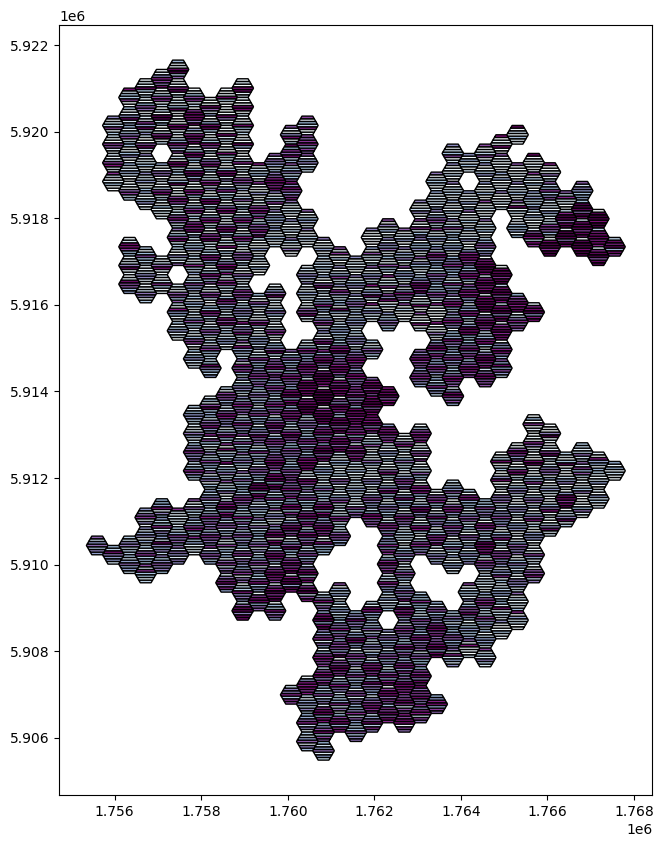

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

for i, rank_col in enumerate(rank_cols):
    df.set_geometry(df.sliced_hexagons.apply(lambda g: g.geoms[i] if g else None)).plot(rank_col, ax=ax, cmap="BuPu", edgecolor="black")

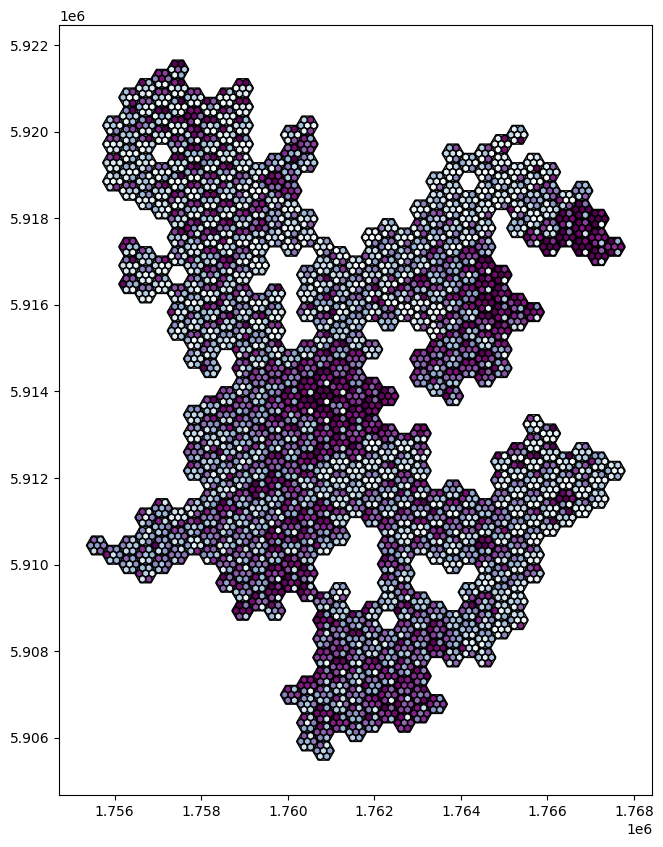

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

df.set_geometry(df.hex_geo).plot("Rank_IMD18", ax=ax, cmap="BuPu", edgecolor="black")
for i, rank_col in enumerate(rank_cols):
    df.set_geometry(df.sub_hexagons.apply(lambda g: g.geoms[i] if g else None)).plot(rank_col, ax=ax, cmap="BuPu", edgecolor="black")

In [24]:
df.set_geometry(df.hex_geo).explore()